# Домашнее задание. Логистическая регрессия для классификации текста
В этом домашнем задании вам предстоит решить каноническую задачу классификации текста --- создать спам-фильтр. Задание большей частью вам придется решать самостоятельно. Для этого можно использовать методы, которые мы проходили на семинаре.

## Данные и посылка
Как и во многих следующих домашних заданиях курса, в этом задании мы будем проверять и оценивать вашу посылку так, как это происходит на конкурсах по машинному обучению (например, на платформе kaggle.com). Для этого мы предварительно разделили данные в задании на две части.

* `data_train.csv`. В каждой строчке файла `data_train.csv` указан текст, который необходимо классифицировать, (столбец `Message`) и целевая переменная (столбец `Category`), принимающая 2 значения: "spam" и "ham", где spam --- это спамовое сообщение, а ham --- просто sms-ка. На этом наборе данных вам необходимо создать и обучить модель.
* `data_scoring.csv`. В каждой строчке файла `data_scoring.csv` указан текст, который необходимо классифицировать, используя обученную модель. Полученные предсказания необходимо записать в файл `submission.csv` и сдать в соответствующий шаг на Stepik. Количество попыток ограничено 100 штук.

Также мы предоставляем файл [`sample_submission.csv`](https://drive.google.com/file/d/1uGPbOSiZx0S9dTdQnam16ncXE6w0JvFm/view?usp=share_link). Это образец посылки --- ваш файл `submission.csv` должен быть оформлен таким же образом.

## Целевая метрика и выставление баллов
Целевая метрика в этой задаче --- ROC-AUC. Именно по ней система будет выставлять вам баллы. Минимальное значение ROC-AUC, за которое ставятся баллы, равно $lb=0.90$. Чтобы набрать полный балл за задание, необходимо набрать $ub=0.99$.
Оценка выставляется по формуле
$$\begin{cases}
0, & score \leqslant lb,\\
10 \cdot \frac{score - lb}{ub - lb}, & lb < score < ub,\\
10, & score \geqslant ub.
\end{cases}$$

Обратите внимание: авторы курса не гарантируют, что качество $0.99$ можно получить методами с семинара. Наше решение дает качество 0.974, но скорее всего аккуратным перебором гиперпараметров можно получить баллы выше.

## Ход работы
Мы предлагаем следующий пайплайн работы.
* Загрузка и обработка данных `data_train.csv`. Часть этой загрузки мы сделали за вас. На этом этапе рекомендуем воспользоваться схемой из семинара.
* Обучение первого варианта модели. Выберите любую модель, которую мы рассматривали на семинаре, и посмотрите, какое качество она дает на наших данных (для этого внутри этого пункта выделите небольшую тестовую выборку, в следующих пунктах она вам не пригодится, так как там мы будем использовать кросс-валидацию).
* Написание пайплайна тестирования. Специфика данных состоит в том, что размер `data_train` мал по сравнению с размером `data_scoring`. Поэтому разделять данные в `data_train` на обучающее и тестирующее множество жалко. По этой причине мы рекомендуем вам воспользоваться процедурой кросс-валидации для более надеждного измерения качества модели. Вам поможет `sklearn.model_selection.cross_validate`.
* Обратите внимание, что если при кросс-валидации кодировать с помощью Bag of Words данные на всем обучающем множестве $X$, то это повлечет переобучение (поскольку, например, модель, обученная на фолдах №1, №2, №3, №4, будет иметь информацию о словах, которые встречались в текстах фолда №5, но не будет иметь информацию о словах из `data_scoring`). Поэтому мы рекомендуем вам реализовать кросс-валидацию вручную, для каждого фолда обучая свой Bag Of Words: тогда качество на каждом фолде будет "честным". Для того, чтобы реализовать кросс-валидацию вручную, можно использовать [`sklearn.model_selection.KFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).
Впрочем, хорошие результаты получаются и при использовании стандартной кросс-валидации (но качество на `data_scoring` при сдаче в систему в таком случае может немного упасть).
* Загрузка данных из `data_scoring.csv`, применение модели и создание `submission.csv`. **Обязательно проверьте, что формат файла совпадает с форматом `sample_submission.csv`!**

Желаем удачи!

In [197]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_validate

%matplotlib inline

## Загрузка данных

In [ ]:
!gdown 1yacgNpDCFREwRe0qiOpTyoik2Jz_z-fu  # data_train.csv
!gdown 1yt9p3Syey65CnNJugcFZsNrOGELBd3LS  # data_scoring.csv

In [198]:
data = pd.read_csv('data_train.csv')
data.head()

,Category,Message
0,ham,TODAY is Sorry day.! If ever i was angry with ...
1,ham,I.ll give her once i have it. Plus she said gr...
2,ham,Where is it. Is there any opening for mca.
3,ham,K:)k:)what are detail you want to transfer?acc...
4,ham,"Wen ur lovable bcums angry wid u, dnt take it ..."


<Axes: >

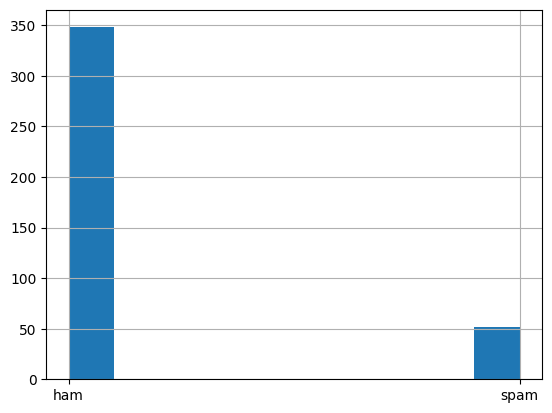

In [84]:
data['Category'].hist()

**Задание**. Обработайте данные: выделите целевую переменную, произведите лемматизацию (по желанию).

In [211]:
X = data['Message']
y, _ = pd.factorize(data['Category'])

In [226]:
import nltk
import spacy
from nltk.corpus import stopwords
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nlp = spacy.load('en_core_web_sm')

from nltk.stem import WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.tokenize import word_tokenize
from tqdm import tqdm_notebook
from gensim.models import Word2Vec


class Word2VecVectorizer:
    def __init__(self, vector_size=100, window=5, min_count=1, workers=4):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.model = None

    def fit(self, X, y=None):
        sentences = [sentence.split() for sentence in X]
        self.model = Word2Vec(sentences, vector_size=self.vector_size, window=self.window,
                              min_count=self.min_count, workers=self.workers)
        return self

    def transform(self, X):
        sentences = [sentence.split() for sentence in X]
        vectors = []
        for sentence in sentences:
            vector = np.mean([self.model.wv[word] for word in sentence if word in self.model.wv], axis=0)
            vectors.append(vector)
        return np.array(vectors)

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

# class TextPreprocessor(BaseEstimator, TransformerMixin):
#     def __init__(self, min_freq=2):
#         self.min_freq = min_freq
#         self.stop_words = set(stopwords.words('english'))
#         self.vocab = None

#     def fit(self, X, y=None):
#         tokenized_texts = [nltk.word_tokenize(text.lower()) for text in X]
#         words = [word for text in tokenized_texts for word in text]
#         word_freq = Counter(words)
#         self.vocab = {word for word, freq in word_freq.items() if freq >= self.min_freq}
#         return self

#     def transform(self, X):
#         processed_texts = []
#         for text in X:
#             doc = nlp(text.lower())
#             lemmatized_tokens = [token.lemma_ for token in doc if token.is_alpha]
#             filtered_tokens = [token for token in lemmatized_tokens if token not in self.stop_words and token in self.vocab]
#             processed_texts.append(' '.join(filtered_tokens))
#         return processed_texts

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [" ".join([self.lemmatizer.lemmatize(word) for word in word_tokenize(text.lower())]) for text in X]
        # tokens = [list(filter(str.isalpha, word_tokenize(text.lower()))) for text in tqdm_notebook(X)]
        # return [' '.join([self.lemmatizer.lemmatize(word) for word in array]) for array in tqdm_notebook(tokens)]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Обучение первого варианта модели
**Задание.** Выделите (только для этого пункта) из data_train тестовую часть. Обучите какую-то из моделей, которые мы использовали на семинаре, и посчитайте качество на тестовых данных.

In [213]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Написание пайплайна тестирования
Задание. Напишите схему кросс-валидации, которая будет тестировать качество модели с данными параметрами.

In [350]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier


pipeline = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', 'passthrough'),
    ('classifier', 'passthrough')
])

param_grid = [
    # {
    #     'vectorizer': [CountVectorizer()],
    #     'vectorizer__max_features': [5000],
    #     'vectorizer__ngram_range': [(1, 1), (1, 2)],
    #     'classifier': [LogisticRegression()],
    #     'classifier__C': [0.1, 1.0, 10.0],
    #     'classifier__solver': ['lbfgs'],
    #     'classifier__max_iter': [100, 200]
    # },
    # {
    #     'vectorizer': [CountVectorizer()],
    #     'classifier': [LogisticRegression()],
    #     'classifier__C': [0.1, 1.0, 10.0],
    #     'classifier__solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
    #     'classifier__max_iter': [100, 200, 300],
    #     'classifier__penalty': ['l1', 'l2']
    # },
    # {
    #     'vectorizer': [TfidfVectorizer()],
    #     'classifier': [LogisticRegression()],
    #     'classifier__C': [17.0],
    #     'classifier__solver': ['saga'],
    #     'classifier__max_iter': [37],
    #     'classifier__penalty': ['l2']
    # },
    {
        'vectorizer': [TfidfVectorizer()],
        'classifier': [LogisticRegression()],
        'vectorizer__ngram_range': [(1, 2)]
    },
    # {
    #     'vectorizer': [TfidfVectorizer()],
    #     'classifier': [RandomForestClassifier()],
    #     'classifier__n_estimators': [200],
    #     'classifier__max_depth': [None, 10, 20],
    #     'classifier__min_samples_split': [2, 5, 10],
    #     'classifier__min_samples_leaf': [1, 2, 4],
    #     'classifier__max_features': ['auto', 'sqrt'],
    #     'classifier__criterion': ['gini', 'entropy']
    # }
    # {
    #     'vectorizer': [TfidfVectorizer()],
    #     'vectorizer__max_features': [5000, 10000],
    #     'vectorizer__ngram_range': [(1, 1), (1, 2)],
    #     'classifier': [LogisticRegression()],
    #     'classifier__C': [0.1],
    #     'classifier__solver': ['lbfgs'],
    #     'classifier__max_iter': [100, 1000]
    # },
    # {
    #     'vectorizer': [TfidfVectorizer()],
    #     'vectorizer__max_features': [5000],
    #     'vectorizer__ngram_range': [(1, 3)],
    #     'classifier': [LogisticRegression()],
    #     'classifier__C': [17.0],
    #     'classifier__solver': ['saga'],
    #     'classifier__max_iter': [100],
    #     'classifier__penalty': ['l2']
    # },
    # {
    #     'vectorizer': [Word2VecVectorizer()],
    #     'vectorizer__window': [5],
    #     'vectorizer__vector_size': [100],
    #     'vectorizer__min_count': [1],
    #     'vectorizer__workers': [4, 8],
    #     'classifier': [LogisticRegression()],
    #     'classifier__C': [0.1],
    #     'classifier__solver': ['lbfgs'],
    #     'classifier__max_iter': [100, 1000]
    # },
    # {
    #     'vectorizer': [CountVectorizer()],
    #     'vectorizer__max_features': [5000],
    #     'vectorizer__ngram_range': [(1, 1), (1, 2)],
    #     'classifier': [MultinomialNB()]
    # },
    # {
    #     'vectorizer': [TfidfVectorizer()],
    #     'vectorizer__max_features': [5000],
    #     'vectorizer__ngram_range': [(1, 1), (1, 2)],
    #     'classifier': [RandomForestClassifier()],
    #     'classifier__n_estimators': [100, 200],
    #     'classifier__max_depth': [None, 10, 20]
    # }
]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipeline, param_grid, cv=kf, scoring='roc_auc', n_jobs=-1)

## Выбор лучшей модели
Протестируйте с помощью написанного пайплайна несколько моделей, которые мы рассматривали на семинаре. Выберите ту из них, которая дает лучшее среднее качество на кросс-валидации.

In [345]:
gs.fit(X_train, y_train)

print("Наилучшие параметры:", gs.best_params_)
print("Лучшее качество (ROC-AUC):", gs.best_score_)

results = gs.cv_results_
results_df = pd.DataFrame(results)
print(results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']])

Наилучшие параметры: {'classifier': LogisticRegression(solver='saga'), 'classifier__solver': 'saga', 'vectorizer': TfidfVectorizer(ngram_range=(1, 2)), 'vectorizer__ngram_range': (1, 2)}
Лучшее качество (ROC-AUC): 0.9851177005031062
                                              params  mean_test_score  \
0  {'classifier': LogisticRegression(solver='saga...         0.985118   

   std_test_score  rank_test_score  
0        0.014011                1  


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Обучение финальной модели
После выбора лучшей модели, обучите ее на всех доступных данных (`data_train`).

In [346]:
best_model = gs.best_estimator_
best_model.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('preprocessor', TextPreprocessor()),
                ('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('classifier', LogisticRegression(solver='saga'))])

## Применение модели на data_scoring и формирование submission
Загрузите данные из `data_scoring.csv`. Обработайте их так же, как вы обработали `data_train.csv`. Примените лучшую модель и сформируйте submission. Сдайте ее на Stepik.

**Обратите внимание, что метрика, используемая в задании --- ROC-AUC. Поэтому вам необходимо предсказать не класс, а вероятность класса `spam`.**

In [347]:
data_scoring = pd.read_csv('data_scoring.csv')
data_scoring.head()

,Message
0,"Hurry up, I've been weed-deficient for like th..."
1,Sounds like a plan! Cardiff is still here and ...
2,Is it your yahoo boys that bring in the perf? ...
3,"K, I'll work something out"
4,Hi im having the most relaxing time ever! we h...


In [348]:
y_scoring = best_model.predict_proba(data_scoring['Message'])[:, 1]

In [349]:
pd.Series(y_scoring, name='score').to_csv('submission.csv', index=None)